<a href="https://colab.research.google.com/github/cameronskim/DataScienceWorks/blob/main/FinalProject_CameronKIM_DataScience_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[CFTC] Retrieved FCM/RFED table with shape: (10, 3)

[CFTC] First few rows of FCM/RFED data:
                    0         1           2
0                2025  PDF Link  Excel Link
1  September 30, 2025       PDF       Excel
2     August 31, 2025       PDF       Excel
3       July 31, 2025       PDF       Excel
4       June 30, 2025       PDF       Excel
[IG] Parsed pairs: ['EUR/USD', 'USD/JPY', 'GBP/USD', 'AUD/USD', 'USD/CAD', 'USD/CNY', 'USD/CHF', 'USD/HKD', 'EUR/GBP', 'USD/KRW']
[OANDA] Error fetching popular pairs: 403 Client Error: Forbidden for url: https://www.oanda.com/us-en/trade-tap-blog/trading-knowledge/most-popular-currency-pairs/

[Pairs] Final FX pair universe:
  AUD/USD     base weight ≈ 0.069
  EUR/GBP     base weight ≈ 0.075
  EUR/USD     base weight ≈ 0.241
  GBP/USD     base weight ≈ 0.109
  USD/CAD     base weight ≈ 0.061
  USD/CHF     base weight ≈ 0.043
  USD/CNY     base weight ≈ 0.092
  USD/HKD     base weight ≈ 0.028
  USD/JPY     base weight ≈ 0.163
  USD/KRW

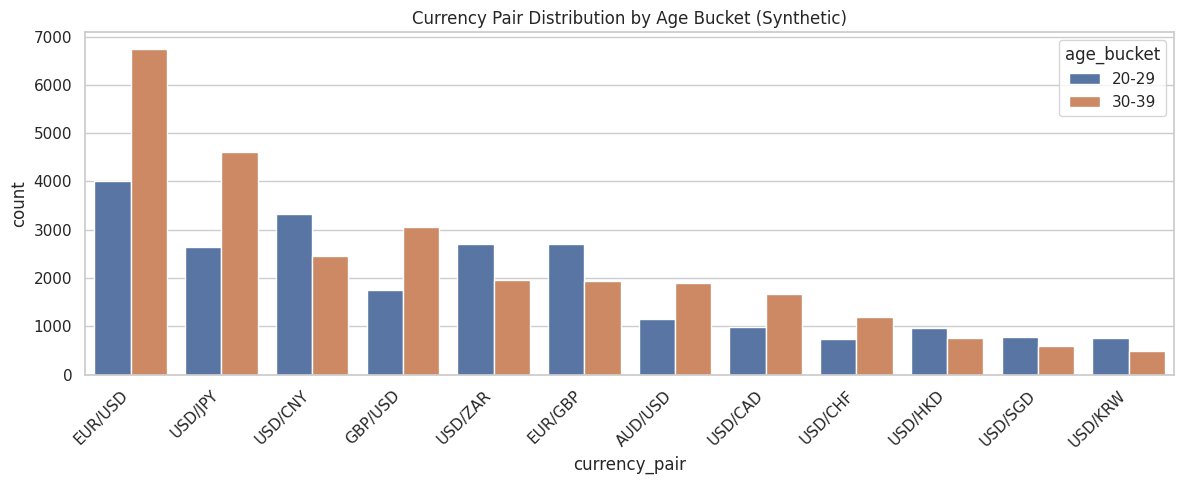

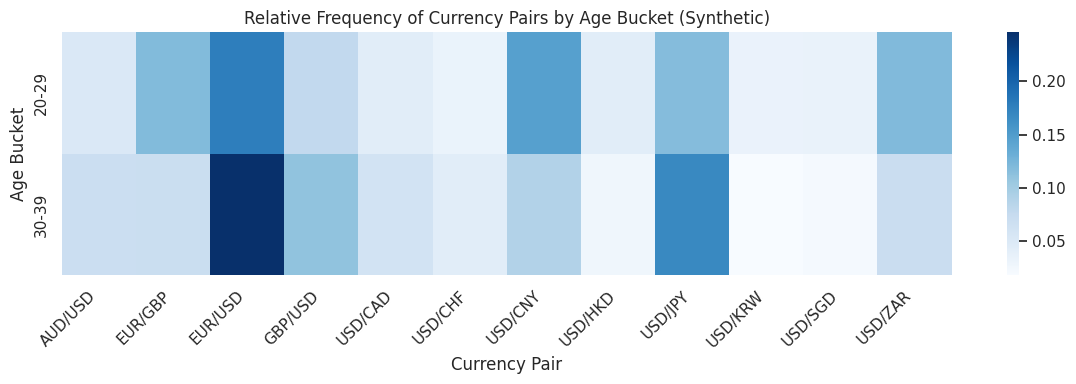


=== Chi-square test: age_bucket vs currency_pair ===
Chi² statistic: 2054.47
Degrees of freedom: 11
p-value: 0.0
=> Reject H0: Age bucket and currency pair are NOT independent.

=== Multinomial Logit: currency_pair ~ age_bucket + time_of_day ===
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                33297
Model:                        MNLogit   Df Residuals:                    33277
Method:                           MLE   Df Model:                           16
Date:                Mon, 08 Dec 2025   Pseudo R-squ.:                 0.01219
Time:                        04:07:48   Log-Likelihood:                -51193.
converged:                       True   LL-Null:                       -51824.
Covariance Type:            nonrobust   LLR p-value:                4.434e-259
                y=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm # Added for direct MNLogit
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


def fetch_cftc_fcm_table():
    """
    Scrape the CFTC 'Financial Data for FCMs and RFEDs' page.
    This is mainly for context / broker list; we don't use it directly
    in the simulation but you can inspect it for your write-up.

    Returns:
        pd.DataFrame or None
    """
    url = "https://www.cftc.gov/MarketReports/financialfcmdata/index.htm"
    try:
        tables = pd.read_html(url)
        if not tables:
            print("[CFTC] No tables found on the page.")
            return None
        fcm_df = tables[0]
        print("[CFTC] Retrieved FCM/RFED table with shape:", fcm_df.shape)
        return fcm_df
    except Exception as e:
        print(f"[CFTC] Error fetching FCM/RFED data: {e}")
        return None


def fetch_ig_top_pairs():
    """
    Scrape IG 'Top 10 most traded currency pairs' article to get an ordered list.

    Returns:
        list of str (e.g. ['EUR/USD', 'USD/JPY', ...])
    """
    url = "https://www.ig.com/en/trading-strategies/top-10-most-traded-currency-pairs-191206"
    pairs = []
    try:
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "html.parser")

        # Look for LI elements that contain something like "EUR/USD"
        for li in soup.find_all("li"):
            text = li.get_text(" ", strip=True)
            if "/" in text:
                for tok in text.split():
                    if "/" in tok and tok.count("/") == 1 and len(tok) <= 10:
                        cc = tok.strip("()[],:;.")
                        # Very simple FX pair sanity check
                        legs = cc.split("/")
                        if len(legs) == 2 and all(2 < len(x) <= 4 for x in legs):
                            pairs.append(cc.upper())
                            break

        # Deduplicate preserving order
        seen, ordered = [] , []
        for p in pairs:
            if p not in seen:
                seen.append(p)
                ordered.append(p)

        print("[IG] Parsed pairs:", ordered[:10])
        return ordered
    except Exception as e:
        print(f"[IG] Error fetching top pairs: {e}")
        return []


def fetch_oanda_popular_pairs():
    """
    Scrape OANDA "most popular currency pairs" article (if reachable).

    Returns:
        list of str
    """
    url = "https://www.oanda.com/us-en/trade-tap-blog/trading-knowledge/most-popular-currency-pairs/"
    pairs = []
    try:
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "html.parser")

        for li in soup.find_all("li"):
            text = li.get_text(" ", strip=True)
            if "/" in text:
                for tok in text.split():
                    if "/" in tok and tok.count("/") == 1 and len(tok) <= 10:
                        cc = tok.strip("()[],:;.")
                        legs = cc.split("/")
                        if len(legs) == 2 and all(2 < len(x) <= 4 for x in legs):
                            pairs.append(cc.upper())
                            break

        seen, ordered = set(), []
        for p in pairs:
            if p not in seen:
                seen.add(p)
                ordered.append(p)

        print("[OANDA] Parsed pairs:", ordered[:10])
        return ordered
    except Exception as e:
        print(f"[OANDA] Error fetching popular pairs: {e}")
        return []


def get_bis_style_weights():
    """
    Hard-code BIS-style global FX pair shares (approximate) as base popularity.

    Numbers adapted from public summaries (BIS/Reuters/RBA-type sources),
    just to anchor the simulation; they don't have to be exact.

    Returns:
        dict: { 'PAIR': share, ... } where shares roughly sum to 1
    """
    # Example approximate shares (% of global volume, normalized later)
    pair_shares = {
        "EUR/USD": 0.212,
        "USD/JPY": 0.143,
        "USD/CNY": 0.081,
        "GBP/USD": 0.096,
        "USD/CAD": 0.054,
        "AUD/USD": 0.061,
        "USD/CHF": 0.038,
        "USD/HKD": 0.025,
        "USD/SGD": 0.020,
        "USD/KRW": 0.018,
    }
    total = sum(pair_shares.values())
    for k in pair_shares:
        pair_shares[k] /= total  # normalize to sum to 1
    return pair_shares


def build_pair_universe():
    """
    Combine BIS-style weights with IG and OANDA lists to:
    - Create full pair list.
    - Assign base popularity weights.

    Returns:
        pairs : list of str
        base_weights : np.array (same length, sum to 1)
        majors : set of pairs considered "majors"
    """
    ig_pairs = fetch_ig_top_pairs()
    oanda_pairs = fetch_oanda_popular_pairs()
    bis_weights = get_bis_style_weights()

    # Start with BIS pairs as the core
    all_pairs = set(bis_weights.keys())

    # Add IG & OANDA pairs
    for p in ig_pairs + oanda_pairs:
        all_pairs.add(p)

    all_pairs = sorted(all_pairs)

    # Base weights:
    # If pair in BIS set, use those weights.
    # If not, assign a small tail weight.
    n_extra = len([p for p in all_pairs if p not in bis_weights])
    extra_total = 0.15  # 15% weight for the non-BIS tail
    tail_weight = extra_total / max(n_extra, 1)

    weights = []
    for p in all_pairs:
        if p in bis_weights:
            weights.append(bis_weights[p] * (1.0 - extra_total))  # scale BIS block
        else:
            weights.append(tail_weight)

    weights = np.array(weights, dtype=float)
    weights /= weights.sum()  # renormalize

    # Define majors (you can tweak this list)
    majors_set = {
        "EUR/USD", "USD/JPY", "GBP/USD",
        "AUD/USD", "USD/CHF", "USD/CAD"
    }

    print("\n[Pairs] Final FX pair universe:")
    for p, w in zip(all_pairs, weights):
        print(f"  {p:10s}  base weight \u2248 {w:.3f}")

    return all_pairs, weights, majors_set


def generate_synthetic_trades(n_trades=100_000, seed=123):
    """
    Generate synthetic trade-level data for US retail traders aged 20\u201339.

    Behavioural assumptions:
    - Age buckets: 20\u201329 vs 30\u201339
      * 45% of trades from 20\u201329, 55% from 30\u201339.
    - 30s overweight majors; 20s overweight non-majors (exotics/crypto-FX etc.).
    - 20s trade more at "Night" and "Evening"; 30s more in "Morning"/"Afternoon".

    Returns:
        df : pd.DataFrame with columns:
            trader_id, age, age_bucket, currency_pair, time_of_day
    """
    np.random.seed(seed)

    pairs, base_weights, majors = build_pair_universe()
    pairs = np.array(pairs)
    base_weights = np.array(base_weights)

    # Age buckets
    age_buckets = ["20-29", "30-39"]
    age_bucket_probs = [0.45, 0.55]  # tweak if desired

    age_bucket_sample = np.random.choice(age_buckets, size=n_trades, p=age_bucket_probs)

    # Actual ages uniform within bucket
    ages = []
    for b in age_bucket_sample:
        if b == "20-29":
            ages.append(np.random.randint(20, 30))
        else:
            ages.append(np.random.randint(30, 40))
    ages = np.array(ages)

    # Identify majors vs non-majors for behaviour tilt
    is_major = np.array([p in majors for p in pairs])
    is_non_major = ~is_major

    major_sum = base_weights[is_major].sum()
    non_major_sum = base_weights[is_non_major].sum()

    # Age 30\u201339: 70% of mass on majors, 30% on non-majors
    w_30 = np.zeros_like(base_weights)
    if major_sum > 0:
        w_30[is_major] = 0.7 * (base_weights[is_major] / major_sum)
    if non_major_sum > 0:
        w_30[is_non_major] = 0.3 * (base_weights[is_non_major] / non_major_sum)

    # Age 20\u201329: 50% of mass on majors, 50% on non-majors (more adventurous)
    w_20 = np.zeros_like(base_weights)
    if major_sum > 0:
        w_20[is_major] = 0.5 * (base_weights[is_major] / major_sum)
    if non_major_sum > 0:
        w_20[is_non_major] = 0.5 * (base_weights[is_non_major] / non_major_sum)

    # Time-of-day buckets
    # We'll define 4 slots: Morning, Afternoon, Evening, Night
    # 20s: more Evening/Night; 30s: more Morning/Afternoon
    tod_labels = ["Morning", "Afternoon", "Evening", "Night"]
    tod_probs_20 = np.array([0.20, 0.25, 0.30, 0.25])
    tod_probs_30 = np.array([0.30, 0.35, 0.20, 0.15])

    time_of_day = []
    currency_pairs = []

    for b in age_bucket_sample:
        if b == "20-29":
            # Time-of-day
            tod = np.random.choice(tod_labels, p=tod_probs_20)
            time_of_day.append(tod)
            # Pair
            cp = np.random.choice(pairs, p=w_20)
            currency_pairs.append(cp)
        else:
            tod = np.random.choice(tod_labels, p=tod_probs_30)
            time_of_day.append(tod)
            cp = np.random.choice(pairs, p=w_30)
            currency_pairs.append(cp)

    time_of_day = np.array(time_of_day)
    currency_pairs = np.array(currency_pairs)

    # Trader IDs (not strictly used, but good to have)
    trader_ids = np.random.randint(100000, 999999, size=n_trades)

    df = pd.DataFrame({
        "trader_id": trader_ids,
        "age": ages,
        "age_bucket": age_bucket_sample,
        "currency_pair": currency_pairs,
        "time_of_day": time_of_day
    })

    return df


def plot_pair_distributions(df):
    """
    Plot bar charts comparing currency pair distribution by age_bucket.
    """
    plt.figure(figsize=(12, 5))
    sns.countplot(
        data=df,
        x="currency_pair",
        hue="age_bucket",
        order=df["currency_pair"].value_counts().index
    )
    plt.xticks(rotation=45, ha="right")
    plt.title("Currency Pair Distribution by Age Bucket (Synthetic)")
    plt.tight_layout()
    plt.show()


def plot_heatmap(df):
    """
    Plot a heatmap of normalized frequencies (age_bucket \u00D7 currency_pair).
    """
    ctab = pd.crosstab(df["age_bucket"], df["currency_pair"], normalize="index")
    plt.figure(figsize=(12, 4))
    sns.heatmap(ctab, annot=False, cmap="Blues")
    plt.title("Relative Frequency of Currency Pairs by Age Bucket (Synthetic)")
    plt.ylabel("Age Bucket")
    plt.xlabel("Currency Pair")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def chi_square_test(df):
    """
    Run \u03C7\u00B2 test of independence between age_bucket and currency_pair.
    """
    ctab = pd.crosstab(df["age_bucket"], df["currency_pair"])
    chi2, p, dof, expected = chi2_contingency(ctab)
    print("\n=== Chi-square test: age_bucket vs currency_pair ===")
    print("Chi\u00B2 statistic:", round(chi2, 2))
    print("Degrees of freedom:", dof)
    print("p-value:", p)
    if p < 0.05:
        print("=> Reject H0: Age bucket and currency pair are NOT independent.")
    else:
        print("=> Fail to reject H0: No strong evidence of dependence.")


def multinomial_logit(df):
    """
    Multinomial logistic regression:
        currency_pair ~ age_bucket + time_of_day

    To keep the model tractable, we restrict to the top 5 most common pairs.
    """
    top_pairs = df["currency_pair"].value_counts().index[:5]
    df_model = df[df["currency_pair"].isin(top_pairs)].copy()

    # Prepare dependent variable (y)
    # Explicitly convert 'currency_pair' to category and then to integer codes
    df_model["currency_pair"] = df_model["currency_pair"].astype("category")
    y = df_model["currency_pair"].cat.codes

    # Prepare independent variables (X)
    # Create dummy variables for categorical predictors and add an intercept
    X = pd.get_dummies(df_model[['age_bucket', 'time_of_day']], drop_first=True)
    X = sm.add_constant(X) # Add intercept term

    # Ensure X has a numeric dtype (float is generally safe for statsmodels)
    X = X.astype(float)

    # Use the direct MNLogit class
    model = sm.MNLogit(y, X)
    result = model.fit(method="newton", maxiter=100, disp=False)

    print("\n=== Multinomial Logit: currency_pair ~ age_bucket + time_of_day ===")
    print(result.summary())


def print_limitations():
    """
    Print a short limitations section you can reuse in your report.
    """
    print("\n=== Limitations of This Study (Synthetic Data) ===")
    print("- The trade-level dataset is fully synthetic, calibrated on public FX turnover")
    print("  summaries and broker marketing materials; it is intended for methodological")
    print("  exploration, not as ground-truth evidence of actual retail behaviour.")
    print("- Age structure and behavioural tilts (e.g., 20s more in exotics, 30s more in majors)")
    print("  are stylized assumptions chosen to illustrate how preferences could differ.")
    print("- Real-world results would require anonymized microdata from one or more US brokers;")
    print("  such data would be subject to strict privacy, regulatory, and sampling constraints.")
    print("- Any inference from this synthetic study should be framed as scenario analysis and")
    print("  proof-of-method rather than a conclusive statement about all US retail FX traders.")


def main():
    # 1. Scrape CFTC for context (optional but nice for your write-up)
    fcm_df = fetch_cftc_fcm_table()
    if fcm_df is not None:
        print("\n[CFTC] First few rows of FCM/RFED data:")
        print(fcm_df.head())

    # 2. Generate synthetic trades
    df = generate_synthetic_trades(n_trades=50_000, seed=42)
    print("\n[Synthetic] Sample of generated trades:")
    print(df.head())

    # 3. EDA: bar charts & heatmap
    plot_pair_distributions(df)
    plot_heatmap(df)

    # 4. \u03C7\u00B2 test
    chi_square_test(df)

    # 5. Multinomial logit model
    multinomial_logit(df)

    # 6. Save dataset for further analysis
    out_file = "synthetic_fx_trades_20_39.csv"
    df.to_csv(out_file, index=False)
    print(f"\n[Synthetic] Saved dataset to '{out_file}'")

    # 7. Limitations
    print_limitations()


if __name__ == "__main__":
    main()